In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
from pandarallel import pandarallel
import string
import numpy as np
import timeit

pandarallel.initialize()

path = r"./resources/software_developer_united_states_1971_20191023_1.csv"


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
def extract_description(df: pd.DataFrame):
    s = df["job_description"]
    s = s.parallel_apply(
        lambda s: s.lower()
        .translate(str.maketrans("", "", string.punctuation + "\xa0"))
        .translate(str.maketrans(string.whitespace, " " * len(string.whitespace)))
    )
    return s


def tokenize(s: pd.Series):
    return s.parallel_apply(lambda s: set(word_tokenize(s)))

def remove_stopwords(s: pd.Series):
    stopwords_set = set(stopwords.words())
    return s.parallel_apply(lambda s: s.difference(stopwords_set))

def filter_word_length(s: pd.Series, n: int):
    return s.parallel_apply(lambda s: {word for word in s if len(word) >= n})

def stem(s: pd.Series):
    ps = PorterStemmer()
    return s.parallel_apply(lambda s: {ps.stem(word) for word in s})


def transformation_pipe(df: pd.DataFrame):
    s = extract_description(df)
    s = tokenize(s)
    s = remove_stopwords(s)
    s = filter_word_length(s, 3)
    s = stem(s)
    return s


In [4]:
rows = pd.read_csv(path)
descriptions = transformation_pipe(rows)
descriptions


0       {protect, success, automot, review, gui, skill...
1       {extens, combin, command, enhanc, skill, open,...
2       {factor, review, s•com, success, contracttohir...
3       {review, enhanc, serviceappl, open, highest, g...
4       {extens, combin, command, enhanc, skill, open,...
                              ...                        
9995    {review, success, transform, skill, previou, s...
9996    {busi, protect, propos, review, essenti, trans...
9997    {model, enhanc, involv, skill, task, unitautom...
9998    {busi, iter, automot, transform, focu, vehicl,...
9999    {busi, iter, creat, success, review, retrospec...
Name: job_description, Length: 10000, dtype: object

In [84]:
from sklearn.feature_extraction.text import CountVectorizer


def benchmark(size):
    cv = CountVectorizer(analyzer=lambda x: x)
    print(f"{size=} counting")
    X = cv.fit_transform(descriptions[:size])
    XX = X.toarray()
    print(f"{size=} starting")
    X_dok = X.todok()
    X_T_dok = X.T.todok()
    X_lil = X.tolil()
    X_T_lil = X.T.tolil()
    X_coo = X.tocoo()
    X_T_coo = X.T.tocoo()
    X_csc = X.tocsc()
    X_T_csc = X.T.tocsc()
    result = [
        timeit.timeit(lambda: np.matmul(XX, XX.T), number=1),
        timeit.timeit(lambda: X_dok * X_T_dok, number=1),
        timeit.timeit(lambda: X_lil * X_T_lil, number=1),
        timeit.timeit(lambda: X_coo * X_T_coo, number=1),
        timeit.timeit(lambda: X_csc * X_T_csc, number=1),
    ]
    print(f"{size=} finished")
    return pd.Series(result, index=["array", "dok", "lil", "coo", "csc"])


In [6]:
sizes = [len(descriptions) // 2 ** n for n in range(0, 6)]

perf_df = pd.DataFrame(sizes, columns=["size"])
perf_df = perf_df.join(perf_df["size"].parallel_apply(lambda x: benchmark(x)))
perf_df


size=5000 counting
size=1250 countingsize=312 countingsize=625 countingsize=2500 counting



size=312 starting
size=10000 counting
size=625 starting
size=1250 starting
size=2500 starting
size=5000 starting
size=312 finished
size=10000 starting
size=625 finished
size=1250 finished
size=2500 finished
size=5000 finished
size=10000 finished


,size,array,dok,lil,coo,csc
0,10000,2287.477513,9.826573,7.830486,7.136818,7.108872
1,5000,491.778550,3.249567,2.055846,1.904178,1.782780
2,2500,127.303987,1.231903,0.736171,0.463649,0.425802
3,1250,28.272474,0.483274,0.197632,0.107760,0.104316
4,625,6.326586,0.275082,0.077902,0.040844,0.033546
5,312,1.200061,0.146941,0.044889,0.018857,0.012553


In [85]:
sizes_extend = [len(descriptions) // 2 ** n for n in range(6, 10)]

perf_df_extend = pd.DataFrame(sizes_extend, columns=["size"])
perf_df_extend = perf_df_extend.join(perf_df_extend["size"].parallel_apply(lambda x: benchmark(x)))
perf_df_extend


size=156 counting
size=39 countingsize=78 countingsize=19 counting


size=19 startingsize=39 starting

size=156 startingsize=78 starting

size=19 finished
size=39 finished
size=78 finished
size=156 finished


,size,array,dok,lil,coo,csc
0,156,0.055820,0.007844,0.003250,0.002254,0.002100
1,78,0.009386,0.006595,0.001320,0.001041,0.000775
2,39,0.002113,0.007414,0.001456,0.000575,0.000411
3,19,0.000273,0.002678,0.000918,0.000552,0.000281


,size,array,dok,lil,coo,csc
9,19,0.000273,0.002678,0.000918,0.000552,0.000281
8,39,0.002113,0.007414,0.001456,0.000575,0.000411
7,78,0.009386,0.006595,0.001320,0.001041,0.000775
6,156,0.055820,0.007844,0.003250,0.002254,0.002100
5,312,1.200061,0.146941,0.044889,0.018857,0.012553
4,625,6.326586,0.275082,0.077902,0.040844,0.033546
3,1250,28.272474,0.483274,0.197632,0.107760,0.104316
2,2500,127.303987,1.231903,0.736171,0.463649,0.425802
1,5000,491.778550,3.249567,2.055846,1.904178,1.782780
0,10000,2287.477513,9.826573,7.830486,7.136818,7.108872


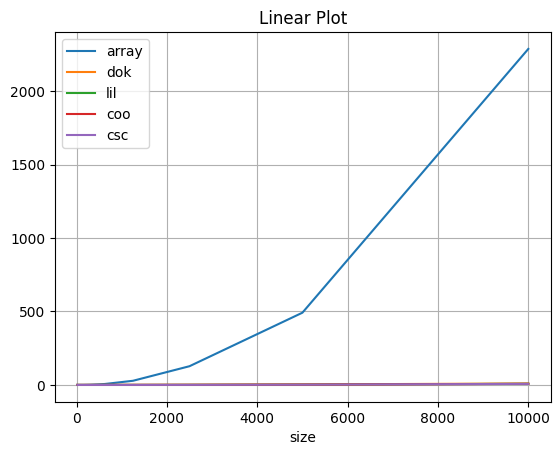

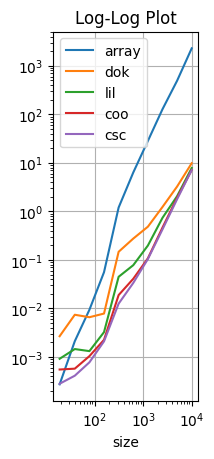

In [93]:
perf_df_full = pd.concat([perf_df, perf_df_extend]).reset_index().drop("index", axis=1)
perf_df_full_sort = perf_df_full.sort_values("size")
perf_df_full_sort.plot(x="size", grid=True, title="Linear Plot")
perf_df_full_sort.plot(x="size", loglog=True, grid=True, title="Log-Log Plot").axis("scaled")
perf_df_full_sort


# Log-Log Analysis
|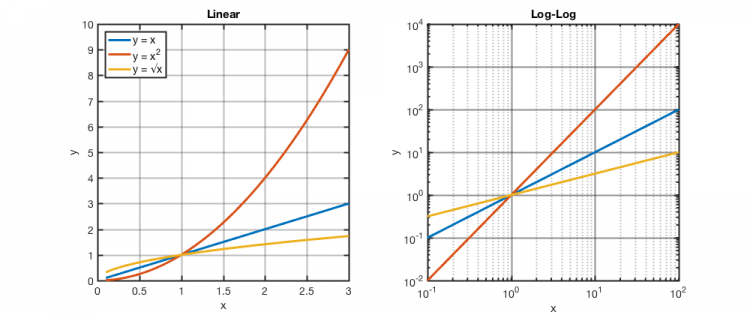|
|---|
|This figure is an example on how polynomial growth looks on Log-Log plot|

`array` line has a much sharper growth than other compression options, meaning compression does help the polynomial run time to scale slower, at the very least with this dataset. In other words the larger the data, the more compression helps.